# Import Packages

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time

# Get the boston housing dataset

In [2]:
import pandas as pd
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :3]])
columns = [
    "CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX",
    "PTRATIO", "B", "LSTAT", "MEDV"
]
df = pd.DataFrame(data, columns=columns)
x = df.iloc[:, :13].values
y = df['MEDV'].values
print(x.shape, y.shape)

(506, 13) (506,)


# Build Dataset and DataLoader

In [3]:
class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# split train, val, test
# train: 60%, val: 20%, test: 20%
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)


train_dataset = MyDataset(x_train, y_train)
val_dataset = MyDataset(x_val, y_val)
test_dataset = MyDataset(x_test, y_test)

# Implement the gradient descent optimizer:

In [4]:
# Compute loss
def compute_loss(X, y, weights):
    predictions = X @ weights
    errors = predictions - y
    return np.mean(errors ** 2) / 2

# Compute gradients
def compute_gradients(X, y, weights):
    predictions = X @ weights
    errors = predictions - y
    gradients = X.T @ errors / len(y)
    return gradients

# Feature scaling with epsilon to avoid division by zero
def scale_features(X):
    means = np.mean(X, axis=0)
    stds = np.std(X, axis=0)
    epsilon = 1e-8  # Small value to ensure we don't divide by zero
    return (X - means) / (stds + epsilon)

# Full batch gradient descent with feature scaling
def full_batch_gradient_descent(X, y, learning_rate=0.001, n_iterations=100000, tolerance=1e-12):
    # Feature scaling
    X_scaled = scale_features(X)
    # Adding a column of ones to account for the bias term (intercept)
    X_scaled = np.hstack([np.ones((X_scaled.shape[0], 1)), X_scaled])

    weights = np.zeros(X_scaled.shape[1])
    loss_history = []
    previous_loss = float('inf')

    for i in range(n_iterations):
        gradients = compute_gradients(X_scaled, y, weights)
        weights -= learning_rate * gradients
        loss = compute_loss(X_scaled, y, weights)
        loss_history.append(loss)

        # Convergence check
        if abs(previous_loss - loss) < tolerance:
            print(f'Convergence reached at iteration {i}.')
            break
        previous_loss = loss

        if i % 100000 == 0:  # More frequent updates to track progress
            print(f'[Full batch] Iteration {i}, loss: {loss}')

    return weights, loss_history

# Stochastic gradient descent with feature scaling
def stochastic_gradient_descent(X, y, learning_rate=0.001, n_iterations=100000, batch_size=1):
    # Feature scaling
    X_scaled = scale_features(X)
    # Adding a column of ones to account for the bias term (intercept)
    X_scaled = np.hstack([np.ones((X_scaled.shape[0], 1)), X_scaled])

    weights = np.zeros(X_scaled.shape[1])
    loss_history = []
    n_samples = len(y)

    for i in range(n_iterations):
        indices = np.random.choice(n_samples, batch_size, replace=False)
        X_batch = X_scaled[indices]
        y_batch = y[indices]
        gradients = compute_gradients(X_batch, y_batch, weights)
        weights -= learning_rate * gradients
        loss = compute_loss(X_scaled, y, weights)
        loss_history.append(loss)

        if i % 100000 == 0:  # More frequent updates to track progress
            print(f'[SGD] Iteration {i}, loss: {loss}')

    return weights, loss_history

# Perform Training

[Full batch] Iteration 0, loss: 304.6162242888869
[Full batch] Iteration 100000, loss: 48.516137294562036
[Full batch] Iteration 200000, loss: 16.480132016878883
[Full batch] Iteration 300000, loss: 12.010927414067474
[Full batch] Iteration 400000, loss: 11.295223841089348
[Full batch] Iteration 500000, loss: 11.120766792672427
[Full batch] Iteration 600000, loss: 11.04129061271373
[Full batch] Iteration 700000, loss: 10.989325578905003
[Full batch] Iteration 800000, loss: 10.951401822310547
[Full batch] Iteration 900000, loss: 10.92282719115038
Full batch gradient descent took 14.26 seconds
[SGD] Iteration 0, loss: 304.6151748139589
[SGD] Iteration 100000, loss: 48.50951146433407
[SGD] Iteration 200000, loss: 16.4771354938917
[SGD] Iteration 300000, loss: 12.011038813804502
[SGD] Iteration 400000, loss: 11.295600077027212
[SGD] Iteration 500000, loss: 11.121036001740308
[SGD] Iteration 600000, loss: 11.041398493078143
[SGD] Iteration 700000, loss: 10.989294987934562
[SGD] Iteration 80

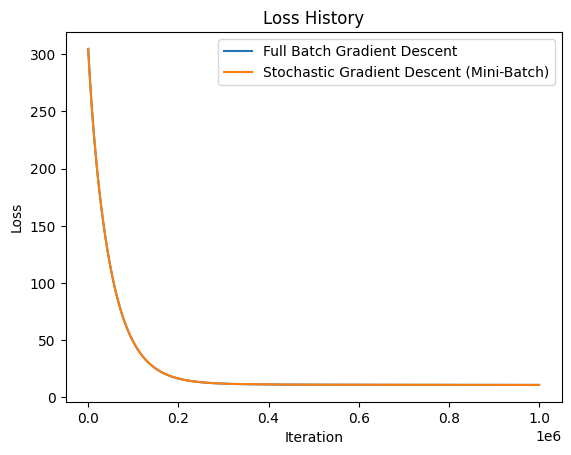

In [5]:
# Add a column of ones to the feature set to account for the bias term
x_train_with_bias = np.hstack((np.ones((len(train_dataset), 1)), train_dataset[:][0]))
x_val_with_bias = np.hstack((np.ones((len(val_dataset), 1)), val_dataset[:][0]))
x_test_with_bias = np.hstack((np.ones((len(test_dataset), 1)), test_dataset[:][0]))

# Perform full-batch gradient descent
start_time = time.time()
weights_full_batch, loss_history_full_batch = full_batch_gradient_descent(x_train_with_bias, y_train, learning_rate=0.00001, n_iterations=1000000)
end_time = time.time()
print(f'Full batch gradient descent took {end_time - start_time:.2f} seconds')

# Perform stochastic gradient descent with mini-batches
start_time = time.time()
weights_sgd, loss_history_sgd = stochastic_gradient_descent(x_train_with_bias, y_train, learning_rate=0.00001, n_iterations=1000000, batch_size=128)
end_time = time.time()
print(f'Stochastic gradient descent took {end_time - start_time:.2f} seconds')

# Plot the loss history for comparison
plt.plot(loss_history_full_batch, label='Full Batch Gradient Descent')
plt.plot(loss_history_sgd, label='Stochastic Gradient Descent (Mini-Batch)')
plt.title('Loss History')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predictions and Evaluation

In [7]:
# Function to predict values using learned weights
def predict(X, weights):
    X = scale_features(X)
    X = np.hstack([np.ones((X.shape[0], 1)), X])
    return X @ weights

# Function to calculate the mean squared error
def calculate_mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Predict values on the validation set
y_pred_full_batch = predict(x_val_with_bias, weights_full_batch)
y_pred_sgd = predict(x_val_with_bias, weights_sgd)

# Compare the weights learned from both methods with the true parameters
print(f"MSE (Full Batch): {calculate_mse(y_val, y_pred_full_batch)}")
print(f"MSE (SGD Mini-Batch): {calculate_mse(y_val, y_pred_sgd)}")

MSE (Full Batch): 23.371822192047716
MSE (SGD Mini-Batch): 23.37056490573411
